# Анализ времен выполнения

## 1 Проверим, что функция реализована правильно

In [16]:
from cython_permutations import permutations as my_permutations
from itertools import permutations as sys_permutations

Про функцию ниже будет написано еще ниже.

In [17]:
def py_permutations(iterable, r=None):
    # permutations('ABCD', 2) --> AB AC AD BA BC BD CA CB CD DA DB DC
    # permutations(range(3)) --> 012 021 102 120 201 210
    pool = tuple(iterable)
    n = len(pool)
    r = n if r is None else r
    if r > n:
        return
    indices = list(range(n))
    cycles = list(range(n, n-r, -1))
    all_permutations = []
    all_permutations.append(tuple(pool[i] for i in indices[:r]))
    while n:
        for i in reversed(range(r)):
            cycles[i] -= 1
            if cycles[i] == 0:
                indices[i:] = indices[i+1:] + indices[i:i+1]
                cycles[i] = n - i
            else:
                j = cycles[i]
                indices[i], indices[-j] = indices[-j], indices[i]
                all_permutations.append(tuple(pool[i] for i in indices[:r]))
                break
        else:
            return tuple(all_permutations)

In [18]:
test_tuple = range(6)
for i in range(1, len(test_tuple)+1):
    assert tuple(sys_permutations(test_tuple, r=i)) == my_permutations(test_tuple, r=i)
    assert tuple(sys_permutations(test_tuple, r=i)) == py_permutations(test_tuple, r=i)
print('All tests passed')

All tests passed


# 2 Сам анализ

Эксперименты проводились для `range()` с параметрами 50, 100, 200, 300. Также было бы нечестно сравнивать с `permutations` из `itertools`, т.к. функция написана на ситоне и она ооочень производительная, поэтому была просто скопирована питоновская апроксимация функции из документации по itertools.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
import seaborn as sns
sns.set_style('whitegrid')

In [23]:
def change_types(df):
    res_df = df.copy()
    res_df['args'] = res_df['args'].apply(lambda x: x[10:-3].strip()).astype(int)
    return res_df

In [24]:
cython_data = change_types(pd.read_csv('cython_permutations', quotechar="'"))
py_data = change_types(pd.read_csv('py_permutations', quotechar="'"))
sys_data = change_types(pd.read_csv('sys_permutations', quotechar="'"))

In [28]:
total_df = pd.DataFrame()
total_df['args']=cython_data['args']
total_df['cython_perm'] = cython_data['func_time']
total_df['py_perm'] = py_data['func_time']
total_df['itertools_perm'] = sys_data['func_time']
total_df

args  cython_perm    py_perm  itertools_perm
0    50     0.029994   0.143233        0.000014
1   100     0.188378   1.011351        0.000016
2   200     1.830315   8.882424        0.000012
3   300     6.836004  30.291692        0.000014

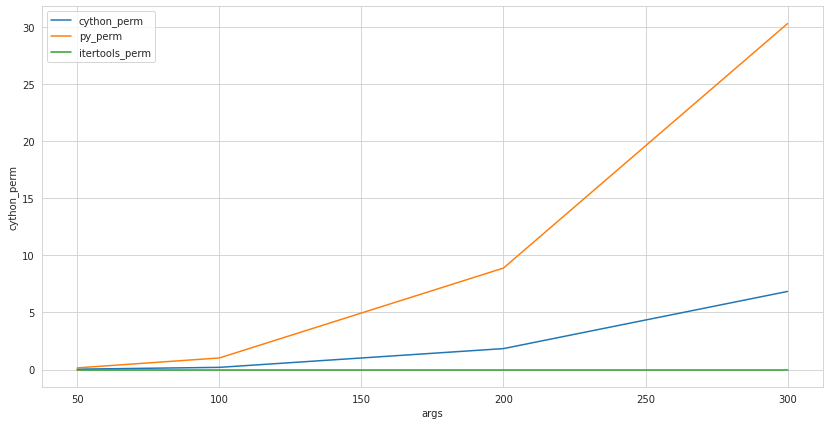

In [30]:
cols_for_graph = ['cython_perm', 'py_perm', 'itertools_perm']
plt.figure(figsize=(14,7))
for col in cols_for_graph:
    sns.lineplot(total_df['args'], total_df[col], label=col)

Как мы видим, наша реализация на ситоне буде побыстрее, чем версия перестановок на питоне, но она все равно не сравнится с версией из библиотеки itertools (тем более тут, как я понимаю, он использовал информацию из предыдущех запусков функции)